Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

### План решения задачи

* [1. Исследовательский анализ данных](#1-bullet)
* [2. Обучение модели](#2-bullet)
* [3. Анализ обученной модели](#3-bullet)

# 1. Исследовательский анализ данных <a id='1-bullet'></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.shape

(7591, 2)

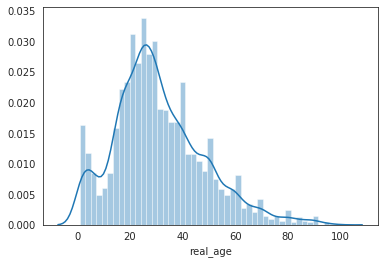

In [7]:
sns.distplot(labels['real_age'])

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


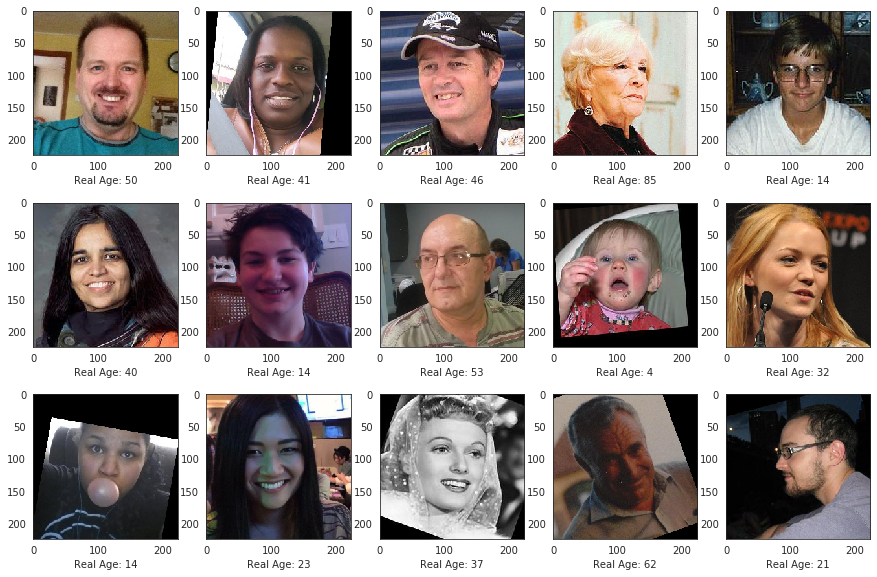

In [8]:
x, y = train_gen_flow.next()

fig = plt.figure(figsize=(15,10))

for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.xlabel('Real Age: ' + str(y[i]))

У нас много фотографий людей в возрасте от 20 до 40 лет, тогда как представителей других возрастов меньше. Еще один момент: мы отсмотрели всего лишь 15 фото, но уже сейчас можно заметить, что присутствуют изображения низкого качества, где с трудом можно разлечить лица.

Это может сказаться на качестве предсказаний.

# 2. Обучение модели <a id='2-bullet'></a>

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Будем использовать предобученную сеть ResNet50, после которой добавим два слоя:

- GlobalAveragePooling2D для усреднения информации по всему изображению
- Dense для классификации с 1-м нейроном и функцией активации ReLU

Подбирать шаг будем с помощью алгоритма оптимизации Adam (lr=0.0001), в качестве функции потерь используем MAE (чтобы модель обучалась быстрее), а количество эпох зададим числом 30.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
	horizontal_flip=True,
        rescale=1/255.)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)        
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0001), loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=30,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)   

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 60 steps
Epoch 1/30
2020-11-10 20:40:58.894420: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-10 20:40:59.188812: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 202.6682 - mae: 10.3836 - val_loss: 628.4039 - val_mae: 20.0095
Epoch 2/30
356/356 - 41s - loss: 82.4216 - mae: 6.9622 - val_loss: 150.0111 - val_mae: 9.3844
Epoch 3/30
356/356 - 41s - loss: 56.5247 - mae: 5.7761 - val_loss: 71.4060 - val_mae: 6.3480
Epoch 4/30
356/356 - 40s - loss: 41.2752 - mae: 4.9258 - val_loss: 86.1789 - val_mae: 7.1197
Epoch 5/30
356/356 - 41s - loss: 32.9490 - mae: 4.3490 - val_loss: 71.7156 - val_mae: 6.3028
Epoch 6/30
356/356 - 41s - loss: 25.0121 - mae: 3.8291 - val_loss: 68.5011 - val_mae: 6.2072
Epoch 7/30
356/356 - 40s - loss: 20.3859 - mae: 3.4200 - val_loss: 69.6253 - val_mae: 6.2388
Epoch 8/30
356/356 - 41s - loss: 16.8193 - mae: 3.1324 - val_loss: 65.3451 - val_mae: 6.1452
Epoch 9/30
356/356 - 41s - loss: 14.5269 - mae: 2.9139 - val_loss: 66.2371 - val_mae: 6.0789
Epoch 10/30
356/356 - 41s - loss: 13.3876 - mae: 2.7991 - val_loss: 71.7950 - val_mae: 6.2292
Epoch 11/30
356/356 - 41s - loss: 14.0370 - mae: 2.8227 - val_loss: 88.5484 - val_mae: 6.9451
Epoch 12/30
356/356 - 41s - loss: 14.0024 - mae: 2.8679 - val_loss: 67.2314 - val_mae: 6.2723
Epoch 13/30
356/356 - 41s - loss: 11.8328 - mae: 2.6131 - val_loss: 67.4479 - val_mae: 6.1824
Epoch 14/30
356/356 - 41s - loss: 10.7784 - mae: 2.4879 - val_loss: 69.1563 - val_mae: 6.3160
Epoch 15/30
356/356 - 42s - loss: 11.3315 - mae: 2.5392 - val_loss: 65.6700 - val_mae: 6.1089
Epoch 16/30
356/356 - 40s - loss: 10.3297 - mae: 2.4653 - val_loss: 62.3795 - val_mae: 5.8728
Epoch 17/30
356/356 - 41s - loss: 9.8390 - mae: 2.3730 - val_loss: 62.6690 - val_mae: 5.8804
Epoch 18/30
356/356 - 41s - loss: 9.2620 - mae: 2.3005 - val_loss: 62.8108 - val_mae: 5.7633
Epoch 19/30
356/356 - 41s - loss: 8.9384 - mae: 2.2473 - val_loss: 64.5641 - val_mae: 6.1394
Epoch 20/30
356/356 - 41s - loss: 8.7642 - mae: 2.2405 - val_loss: 60.2459 - val_mae: 5.8518
Epoch 21/30
356/356 - 41s - loss: 8.6133 - mae: 2.2222 - val_loss: 64.8317 - val_mae: 5.8589
Epoch 22/30
356/356 - 42s - loss: 8.4166 - mae: 2.2029 - val_loss: 62.7744 - val_mae: 5.8500
Epoch 23/30
356/356 - 41s - loss: 8.7566 - mae: 2.2350 - val_loss: 69.6238 - val_mae: 6.2093
Epoch 24/30
356/356 - 41s - loss: 8.4264 - mae: 2.1668 - val_loss: 70.7351 - val_mae: 6.0384
Epoch 25/30
356/356 - 41s - loss: 7.3425 - mae: 2.0630 - val_loss: 63.6531 - val_mae: 5.8080
Epoch 26/30
356/356 - 41s - loss: 7.3060 - mae: 2.0447 - val_loss: 59.4836 - val_mae: 5.8165
Epoch 27/30
356/356 - 41s - loss: 6.3044 - mae: 1.8989 - val_loss: 59.0239 - val_mae: 5.7795
Epoch 28/30
356/356 - 41s - loss: 6.0885 - mae: 1.8683 - val_loss: 63.1615 - val_mae: 6.0510
Epoch 29/30
356/356 - 42s - loss: 5.9485 - mae: 1.8581 - val_loss: 58.3400 - val_mae: 5.6459
Epoch 30/30
356/356 - 41s - loss: 5.8800 - mae: 1.8317 - val_loss: 59.4362 - val_mae: 5.7050
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 59.4362 - mae: 5.7050
Test MAE: 5.7050

```

# 3. Анализ обученной модели <a id='3-bullet'></a>

Изображения в датасете довольно разнородные: где-то изображения лиц крупным планом, а где-то в отдалении. Качество части фото также страдает, что затрудняет процесс обучения модели. Чтобы увеличить размер обучающей выборки, была применена аугментация - отражение по горизонтальной оси. 

Тем не менее, с помощью сверточной нейронной сети на основе ResNet50 удалось добиться значения MAE в 5.70: наша модель определяет возраст человека со средней ошибкой в 6 лет. Этого недостаточно для контроля кассиров при продаже алкоголя, но можно доработать результаты работы модели: от предсказанного возраста отнимать значение MAE и если полученное значение будет ниже 18, то предпринимать меры. Штраф за ошибку в этом деле довольно велик, так что лучше подстраховаться.

Что касаемо разбивки на возрастные группы, то стоит доработать модель. В первую очередь это необходимо сделать с помощью увеличения датасета:
- необходимо добавить больше фотографий детей и людей зрелого возраста
- сделать изображения черно-белыми
- обрезать края, чтобы большую часть фото занимало лицо
- возможно, если бы мы отсортировали изображения по качеству и в процессе обучения продвигались от фото с высоких расрешением к к фото с низким разрешением, то качество предсказания также улучшилось